Finding Key Connectors

It’s your first day on the job at DataSciencester, and the VP of Networking is full of questions about your users. Until now he’s had no one to ask, so he’s very excited to have you aboard.

In particular, he wants you to identify who the “key connectors” are among data scientists. To this end, he gives you a dump of the entire DataSciencester network. (In real life, people don’t typically hand you the data you need. Chapter 9 is devoted to getting data.)

What does this data dump look like? It consists of a list of users, each represented by a dict that contains that user’s id (which is a number) and name (which, in one of the great cosmic coincidences, rhymes with the user’s id):

In [1]:
users = [
    { 'id': 0, 'name': 'Hero' },
    { 'id': 1, 'name': 'Dunn' },
    { 'id': 2, 'name': 'Sue' },
    { 'id': 3, 'name': 'Chi' },
    { 'id': 4, 'name': 'Thor' },
    { 'id': 5, 'name': 'Clive' },
    { 'id': 6, 'name': 'Hicks' },
    { 'id': 7, 'name': 'Devin' },
    { 'id': 8, 'name': 'Kate' },
    { 'id': 9, 'name': 'Klein' }
]

He also gives you the “friendship” data, represented as a list of pairs of IDs:

In [2]:
friendship_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
                    (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

For example, the tuple (0, 1) indicates that the data scientist with id 0 (Hero) and the data scientist with id 1 (Dunn) are friends. The network is illustrated in Figure 1-1.

Having friendships represented as a list of pairs is not the easiest way to work with them. To find all the friendships for user 1, you have to iterate over every pair looking for pairs containing 1. If you had a lot of pairs, this would take a long time.

Instead, let’s create a dict where the keys are user ids and the values are lists of friend ids. (Looking things up in a dict is very fast.)

We’ll still have to look at every pair to create the dict, but we only have to do that once, and we’ll get cheap lookups after that:

In [3]:
friendships = {user['id']: [] for user in users}

for i, j in friendship_pairs:
    friendships[i].append(j)
    friendships[j].append(j)

friendship_pairs

[(0, 1),
 (0, 2),
 (1, 2),
 (1, 3),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (5, 7),
 (6, 8),
 (7, 8),
 (8, 9)]

Now that we have the friendships in a dict, we can easily ask questions of our graph, like “What’s the average number of connections?”

First we find the total number of connections, by summing up the lengths of all the friends lists:

In [4]:
def number_of_friends(user):
    user_id = user['id']
    friend_ids = friendships[user_id]
    return len(friend_ids)

total_connections = sum(number_of_friends(user) for user in users)
total_connections

24

And then we just divide by the number of users:

In [5]:
num_users = len(users)
avg_connections = total_connections / num_users
avg_connections

2.4

It’s also easy to find the most connected people—they’re the people who have the largest numbers of friends.

Since there aren’t very many users, we can simply sort them from “most friends” to “least friends”:

In [6]:
num_friends_by_id = [(user['id'], number_of_friends(user))for user in users]

num_friends_by_id.sort(
    key = lambda id_and_friends : id_and_friends[1],
    reverse= True
)

num_friends_by_id

[(1, 3),
 (2, 3),
 (3, 3),
 (5, 3),
 (8, 3),
 (0, 2),
 (4, 2),
 (6, 2),
 (7, 2),
 (9, 1)]

One way to think of what we’ve done is as a way of identifying people who are somehow central to the network. In fact, what we’ve just computed is the network metric degree centrality (Figure 1-2).

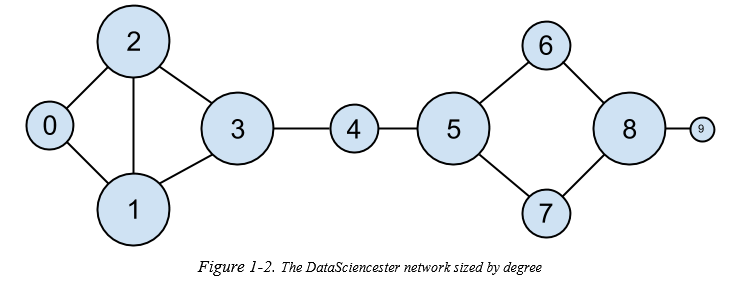

Data Scientists You May Know

While you’re still filling out new-hire paperwork, the VP of Fraternization comes by your desk. She wants to encourage more connections among your members, and she asks you to design a “Data Scientists You May Know” suggester.

Your first instinct is to suggest that users might know the friends of their friends. So you write some code to iterate over their friends and collect the friends’ friends:

In [7]:
def foaf_ids_bad(user):
    '''foaf is short for 'friend of a friend' '''
    return [foaf_id
            for friend_id in friendships[user['id']]
            for foaf_id in friendships[friend_id]]

When we call this on users[0] (Hero), it produces:

In [8]:
foaf_ids_bad(users[0])

[1, 2, 3, 2, 2, 3]

Knowing that people are friends of friends in multiple ways seems like interesting information, so maybe instead we should produce a count of mutual friends. And we should probably exclude people already known to the user:

In [9]:
from collections import Counter                   

def friends_of_friends(user):
    user_id = user['id']
    return Counter(
        foaf_id
        for friend_id in friendships[user_id]     
        for foaf_id in friendships[friend_id]     
        if foaf_id != user_id                     
        and foaf_id not in friendships[user_id]   
    )

print(friends_of_friends(users[3]))

Counter({5: 1})


This correctly tells Chi (id 3) that she has two mutual friends with Hero (id 0) but only one mutual friend with Clive (id 5).

As a data scientist, you know that you also might enjoy meeting users with similar interests. (This is a good example of the “substantive expertise” aspect of data science.) After asking around, you manage to get your hands on this data, as a list of pairs (user_id, interest):

In [10]:
interests = [
    (0, 'Hadoop'), (0, 'Big Data'), (0, 'HBase'), (0, 'Java'),
    (0, 'Spark'), (0, 'Storm'), (0, 'Cassandra'),
    (1, 'NoSQL'), (1, 'MongoDB'), (1, 'Cassandra'), (1, 'HBase'),
    (1, 'Postgres'), (2, 'Python'), (2, 'scikit-learn'), (2, 'scipy'),
    (2, 'numpy'), (2, 'statsmodels'), (2, 'pandas'), (3, 'R'), (3, 'Python'),
    (3, 'statistics'), (3, 'regression'), (3, 'probability'),
    (4, 'machine learning'), (4, 'regression'), (4, 'decision trees'),
    (4, 'libsvm'), (5, 'Python'), (5, 'R'), (5, 'Java'), (5, 'C++'),
    (5, 'Haskell'), (5, 'programming languages'), (6, 'statistics'),
    (6, 'probability'), (6, 'mathematics'), (6, 'theory'),
    (7, 'machine learning'), (7, 'scikit-learn'), (7, 'Mahout'),
    (7, 'neural networks'), (8, 'neural networks'), (8, 'deep learning'),
    (8, 'Big Data'), (8, 'artificial intelligence'), (9, 'Hadoop'),
    (9, 'Java'), (9, 'MapReduce'), (9, 'Big Data')
]

For example, Hero (id 0) has no friends in common with Klein (id 9), but they share interests in Java and big data.

It’s easy to build a function that finds users with a certain interest:

In [11]:
def data_scientists_who_like(target_interest):
    return[user_id
           for user_id, user_interest in interests
           if user_interest == target_interest
    ]

This works, but it has to examine the whole list of interests for every search. If we have a lot of users and interests (or if we just want to do a lot of searches), we’re probably better off building an index from interests to users:

In [12]:
from collections  import defaultdict
from collections import Counter

user_ids_by_interest = defaultdict(list)

for user_id, interest in interests:
    user_ids_by_interest[interest].append(user_id)


interest_by_user_id = defaultdict(list)

for user_id, interest in interests:
    interest_by_user_id[user_id].append(interest)




Now it’s easy to find who has the most interests in common with a given user:

    Iterate over the user’s interests.

    For each interest, iterate over the other users with that interest.

    Keep count of how many times we see each other user.

In code:

In [13]:
def most_common_interest_with(user):
    return Counter(
        interested_user_id
        for interest in interest_by_user_id[user['id']]
        for interested_user_id in user_ids_by_interest[interest]
        if interested_user_id != user['id']
    )

We could then use this to build a richer “Data Scientists You May Know” feature based on a combination of mutual friends and mutual interests. We’ll explore these kinds of applications in Chapter 23.

## Salaries and Experience

Right as you’re about to head to lunch, the VP of Public Relations asks if you can provide some fun facts about how much data scientists earn. Salary data is of course sensitive, but he manages to provide you an anonymous dataset containing each user’s salary (in dollars) and tenure as a data scientist (in years):

In [14]:
salaries_and_tenures = [(83000, 8.7), (88000, 8.1),
                        (48000, 0.7), (76000, 6),
                        (69000, 6.5), (76000, 7.5),
                        (60000, 2.5), (83000, 10),
                        (48000, 1.9), (63000, 4.2)]

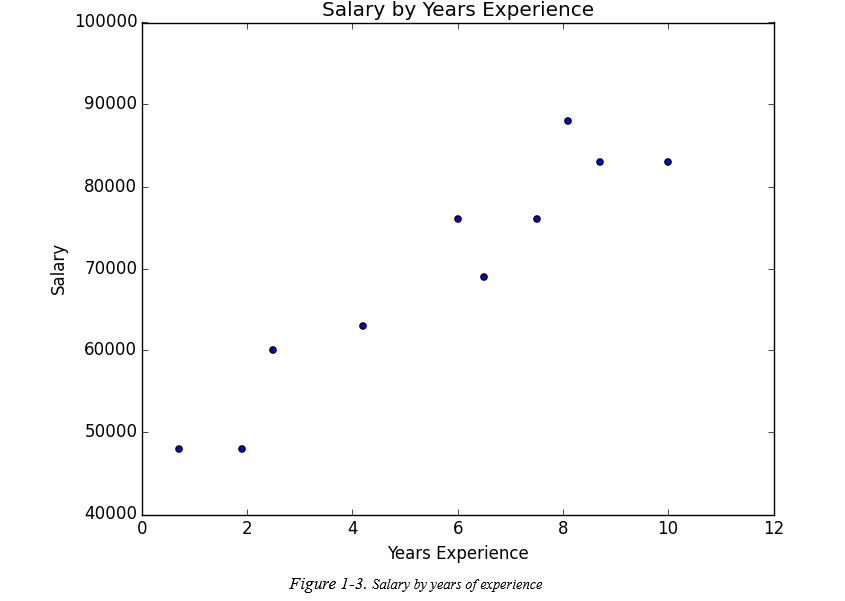

It seems clear that people with more experience tend to earn more. How can you turn this into a fun fact? Your first idea is to look at the average salary for each tenure:

In [15]:
salary_by_ternure = defaultdict(list)

for salary, ternure in salaries_and_tenures:
    salary_by_ternure[ternure].append(salary)

average_salary_by_tenure = {
    tenure: sum(salaries) / len(salaries)
    for tenure, salaries in salary_by_ternure.items()
}

average_salary_by_tenure

{8.7: 83000.0,
 8.1: 88000.0,
 0.7: 48000.0,
 6: 76000.0,
 6.5: 69000.0,
 7.5: 76000.0,
 2.5: 60000.0,
 10: 83000.0,
 1.9: 48000.0,
 4.2: 63000.0}

This turns out to be not particularly useful, as none of the users have the same tenure, which means we’re just reporting the individual users’ salaries:

It might be more helpful to bucket the tenures:

In [16]:
def tenure_bucket(ternure):
    if ternure < 2:
        return 'less than two'
    elif ternure < 5:
        return 'between two and five'
    else:
        return 'more than five'
    
    

Then we can group together the salaries corresponding to each bucket:

In [17]:
salary_by_ternure_bucket = defaultdict(list)

for salary , ternure in salaries_and_tenures:
    bucket = tenure_bucket(ternure)
    salary_by_ternure_bucket[bucket].append(salary)

salary_by_ternure_bucket

defaultdict(list,
            {'more than five': [83000, 88000, 76000, 69000, 76000, 83000],
             'less than two': [48000, 48000],
             'between two and five': [60000, 63000]})

And finally compute the average salary for each group:

In [18]:
average_salary_by_bucket = {
    tenure_bucket: sum(salaries) / len(salaries)
    for tenure_bucket, salaries in salary_by_ternure_bucket.items()
}
average_salary_by_bucket

{'more than five': 79166.66666666667,
 'less than two': 48000.0,
 'between two and five': 61500.0}

But we chose the buckets in a pretty arbitrary way. What we’d really like is to make some statement about the salary effect—on average—of having an additional year of experience. In addition to making for a snappier fun fact, this allows us to make predictions about salaries that we don’t know

## Paid Accounts

When you get back to your desk, the VP of Revenue is waiting for you. She wants to better understand which users pay for accounts and which don’t. (She knows their names, but that’s not particularly actionable information.)

You notice that there seems to be a correspondence between years of experience and paid accounts:

0.7  paid
1.9  unpaid
2.5  paid
4.2  unpaid
6.0  unpaid
6.5  unpaid
7.5  unpaid
8.1  unpaid
8.7  paid
10.0 paid

Users with very few and very many years of experience tend to pay; users with average amounts of experience don’t. Accordingly, if you wanted to create a model—though this is definitely not enough data to base a model on—you might try to predict “paid” for users with very few and very many years of experience, and “unpaid” for users with middling amounts of experience:

In [19]:
def predict_paid_or_unpaid(years_experience):
    if years_experience < 3.0:
        return 'paid'
    elif years_experience < 8.5:
        return 'unpaid'
    else:
        return 'paid'

Of course, we totally eyeballed the cutoffs.

With more data (and more mathematics), we could build a model predicting the likelihood that a user would pay based on his years of experience. 

## Topics of Interest

As you’re wrapping up your first day, the VP of Content Strategy asks you for data about what topics users are most interested in, so that she can plan out her blog calendar accordingly. You already have the raw data from the friend-suggester project:

In [20]:
interests = [
    (0, 'Hadoop'), (0, 'Big Data'), (0, 'HBase'), (0, 'Java'),
    (0, 'Spark'), (0, 'Storm'), (0, 'Cassandra'),
    (1, 'NoSQL'), (1, 'MongoDB'), (1, 'Cassandra'), (1, 'HBase'),
    (1, 'Postgres'), (2, 'Python'), (2, 'scikit-learn'), (2, 'scipy'),
    (2, 'numpy'), (2, 'statsmodels'), (2, 'pandas'), (3, 'R'), (3, 'Python'),
    (3, 'statistics'), (3, 'regression'), (3, 'probability'),
    (4, 'machine learning'), (4, 'regression'), (4, 'decision trees'),
    (4, 'libsvm'), (5, 'Python'), (5, 'R'), (5, 'Java'), (5, 'C++'),
    (5, 'Haskell'), (5, 'programming languages'), (6, 'statistics'),
    (6, 'probability'), (6, 'mathematics'), (6, 'theory'),
    (7, 'machine learning'), (7, 'scikit-learn'), (7, 'Mahout'),
    (7, 'neural networks'), (8, 'neural networks'), (8, 'deep learning'),
    (8, 'Big Data'), (8, 'artificial intelligence'), (9, 'Hadoop'),
    (9, 'Java'), (9, 'MapReduce'), (9, 'Big Data')
]

One simple (if not particularly exciting) way to find the most popular interests is to count the words:

    Lowercase each interest (since different users may or may not capitalize their interests).

    Split it into words.

    Count the results.


In [21]:
words_and_conunts = Counter(word
                            for user, interest in interests
                            for word in interest.lower().split())

words_and_conunts

Counter({'big': 3,
         'data': 3,
         'java': 3,
         'python': 3,
         'learning': 3,
         'hadoop': 2,
         'hbase': 2,
         'cassandra': 2,
         'scikit-learn': 2,
         'r': 2,
         'statistics': 2,
         'regression': 2,
         'probability': 2,
         'machine': 2,
         'neural': 2,
         'networks': 2,
         'spark': 1,
         'storm': 1,
         'nosql': 1,
         'mongodb': 1,
         'postgres': 1,
         'scipy': 1,
         'numpy': 1,
         'statsmodels': 1,
         'pandas': 1,
         'decision': 1,
         'trees': 1,
         'libsvm': 1,
         'c++': 1,
         'haskell': 1,
         'programming': 1,
         'languages': 1,
         'mathematics': 1,
         'theory': 1,
         'mahout': 1,
         'deep': 1,
         'artificial': 1,
         'intelligence': 1,
         'mapreduce': 1})

This makes it easy to list out the words that occur more than once:

In [22]:
for word, count in words_and_conunts.most_common():
    if count > 1:
        print(word, count)

big 3
data 3
java 3
python 3
learning 3
hadoop 2
hbase 2
cassandra 2
scikit-learn 2
r 2
statistics 2
regression 2
probability 2
machine 2
neural 2
networks 2
